In [93]:
# Jun Tu 21-732-722
# Guanda Zhao 21-716-345

In [94]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as sts

In [95]:
data_base_path = "Data/"

cormat_1h = np.load(data_base_path + "cormat_1h.npy")
cormat_1m = np.load(data_base_path + "cormat_1m.npy")

print("Loading is done")

## thread unsafe
figure_uni_index=0
def new_figure():
    global figure_uni_index
    figure_uni_index = figure_uni_index + 1
    fig = plt.figure(figure_uni_index)
    return fig


Loading is done


In [96]:
def lambda_min_max(Q):
    lambda_min = 1 + 1 / Q - 2 * math.sqrt(1/Q)
    lambda_max = 1 + 1 / Q + 2 * math.sqrt(1/Q)
    return lambda_min, lambda_max

def marcenko_pastur(Q, lambda_input):
    lambda_min, lambda_max = lambda_min_max(Q)
    probability = (Q / (2 * math.pi)) * (math.sqrt((lambda_max - lambda_input)*(lambda_input - lambda_min)) / lambda_input)
    return probability

def replace_noise(eigvals, noise, lambda_max):
    count = 0
    while count < len(noise):
        for eigval in eigvals:
            if (eigval < lambda_max):
                eigval = noise[count]
                count += 1  
    return eigvals

Text(0.5, 1.0, 'MP law for 1m')

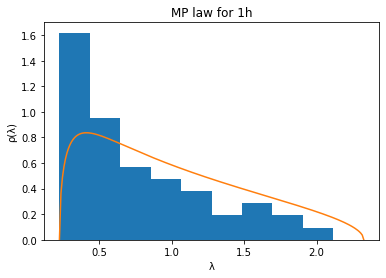

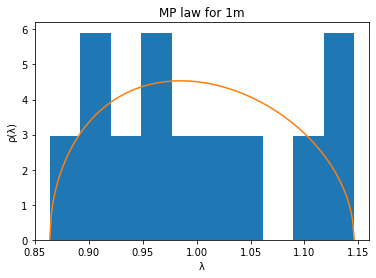

In [97]:
eigval_1h, eigvec_1h = np.linalg.eig(cormat_1h)
eigval_1m, eigvec_1m = np.linalg.eig(cormat_1m)

Q_1h = 3.6289
Q_1m = 200.8969

lambda_min_1h, lambda_max_1h = lambda_min_max(Q_1h)
lambda_min_1m, lambda_max_1m = lambda_min_max(Q_1m)

x_1h = np.arange(lambda_min_1h, lambda_max_1h, (lambda_max_1h - lambda_min_1h)/200)
x_1m = np.arange(lambda_min_1m, lambda_max_1m, (lambda_max_1m - lambda_min_1m)/200)
x_1h = np.append(x_1h, lambda_max_1h)
x_1m = np.append(x_1m, lambda_max_1m)

y_1h = [marcenko_pastur(Q_1h, x) for x in x_1h]
y_1m = [marcenko_pastur(Q_1m, x) for x in x_1m]

new_figure()
plt.hist(eigval_1h, range = (lambda_min_1h, lambda_max_1h), density = True)
plt.plot(x_1h, y_1h)
plt.xlabel('\u03BB')
plt.ylabel('\u03C1(\u03BB)')
plt.title('MP law for 1h')

new_figure()
plt.hist(eigval_1m, range = (lambda_min_1m, lambda_max_1m), density = True)
plt.plot(x_1m, y_1m)
plt.xlabel('\u03BB')
plt.ylabel('\u03C1(\u03BB)')
plt.title('MP law for 1m')

In [98]:
noise_1h = []
signal_1h = []
noise_1m = []
signal_1m = []

for eigval in eigval_1h:
    if (eigval < lambda_max_1h):
        noise_1h.append(eigval)
    else:
        signal_1h.append(eigval)
        
for eigval in eigval_1m:
    if (eigval < lambda_max_1m):
        noise_1m.append(eigval)
    else:
        signal_1m.append(eigval)
        
norm_noise_1h = [lambda_i / sum(noise_1h) * len(noise_1h) for lambda_i in noise_1h]
norm_noise_1m = [lambda_i / sum(noise_1m) * len(noise_1m) for lambda_i in noise_1m]

diagonal_1h = replace_noise(eigval_1h, norm_noise_1h, lambda_max_1h)
diagonal_1m = replace_noise(eigval_1m, norm_noise_1m, lambda_max_1m)

denoised_1h = eigvec_1h * diagonal_1h * eigvec_1h.T
denoised_1m = eigvec_1m * diagonal_1m * eigvec_1m.T

D_1h = np.empty(denoised_1h.shape)
D_1m = np.empty(denoised_1m.shape)

for i in range(0, denoised_1h.shape[0]):
    D_1h[i,i] = 1 / math.sqrt(denoised_1h[i,i])
    
for i in range(0, denoised_1m.shape[0]):
    D_1m[i,i] = 1 / math.sqrt(denoised_1m[i,i])
    
denoised_1h = D_1h * diagonal_1h * D_1h.T
denoised_1m = D_1m * diagonal_1m * D_1m.T

print('denoised_1h:\n', denoised_1h)
print('\n')
print('denoised_1m:\n', denoised_1m)

denoised_1h:
 [[ 242.03459318    0.            0.         ...    0.
     0.            0.        ]
 [   0.         5459.74142657    0.         ...    0.
     0.            0.        ]
 [   0.            0.          160.61675632 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... 3127.73298711
     0.            0.        ]
 [   0.            0.            0.         ...    0.
    51.01820466    0.        ]
 [   0.            0.            0.         ...    0.
     0.          195.41779956]]


denoised_1m:
 [[ 1.40363280e+002  7.32593349e-311 -1.24925887e+000 ... -3.19957243e-002
  -3.12812728e-003  3.06330835e-002]
 [ 7.21010546e-310  4.76328674e+002 -1.13654080e-001 ... -2.47207177e-003
   3.05296652e-003  1.82318349e-002]
 [-1.39907938e+001 -1.29329113e-001  4.97630148e+002 ... -1.08522623e-002
   1.29889454e-002 -9.70804507e-004]
 ...
 [-2.10737289e+000 -1.65436706e-002 -6.38233819e-002 ...  8.03556983e+003
  -9.99560643e-004 -2.74654514e-00

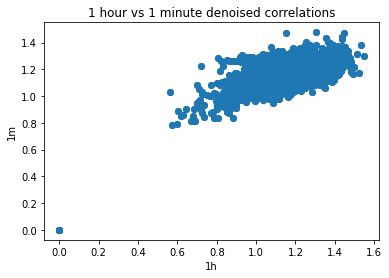

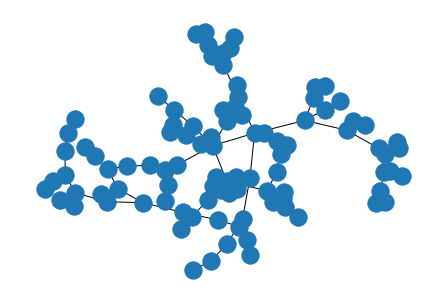

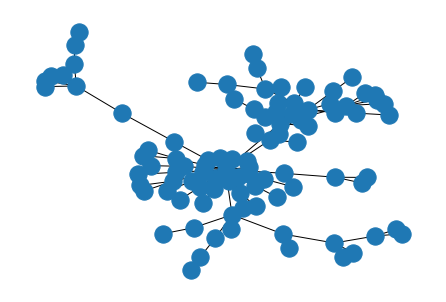

In [112]:
D_1h = np.empty(cormat_1h.shape)
D_1m = np.empty(cormat_1m.shape)

for i in range(0, cormat_1h.shape[0]):
    for j in range(0, cormat_1h.shape[1]):
        D_1h[i,j] = math.sqrt(2 * (1 - cormat_1h[i,j])) 

for i in range(0, cormat_1m.shape[0]):
    for j in range(0, cormat_1m.shape[1]):
        D_1m[i,j] = math.sqrt(2 * (1 - cormat_1m[i,j])) 
        
new_figure()
plt.scatter(x = D_1h, y = D_1m)
plt.xlabel('1h')
plt.ylabel('1m')
plt.title('1 hour vs 1 minute denoised correlations')

G_1h = nx.from_numpy_matrix(D_1h)
MST_1h = nx.minimum_spanning_tree(G_1h)
new_figure()
nx.draw(MST_1h)

G_1m = nx.from_numpy_matrix(D_1m)
MST_1m = nx.minimum_spanning_tree(G_1m)
new_figure()
nx.draw(MST_1m)